# Client orders :: *ipynb solution draft* <br>

## Read Data

In [384]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from persiantools import jdatetime

from scipy.stats import boxcox
from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [385]:
# Read data / Clean version of sales_data.csv

df = pd.read_csv("sales_data_clean.csv")
df.head()

,Order_ID,Branch,Order_Date,Order_Priority,Manufacturer,Model_Name,Category,Screen_Size,RAM,OS,...,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Rating,Store
0,0,Hamedan,1396-10-26,H,Dell,Vostro 3568,Notebook,15.6,8,Windows,...,2.5,256,0,0,0,256,AMD,Radeon R5 M420,NaN,NaN
1,1,Kermanshah,1394-04-21,H,Lenovo,Yoga 720-13IKB,2 in 1 Convertible,13.3,8,Windows,...,2.5,256,0,0,0,256,Intel,HD Graphics 620,NaN,NaN
2,2,Rasht,1402-05-24,M,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,8,Windows,...,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,NaN,NaN
3,3,Kermanshah,1397-06-17,H,Dell,Inspiron 5370,Ultrabook,13.3,8,Windows,...,1.8,256,0,0,0,256,AMD,Radeon 530,NaN,NaN
4,4,Karaj,1392-09-30,L,Acer,Aspire E5-576G,Notebook,15.6,4,Windows,...,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,NaN,NaN


In [386]:
# Convert Shamsi dates to Miladi

def vectorized_convert_shamsi_to_datetime(years, months, days):
    gregorian_dates = [
        jdatetime.JalaliDate(int(y), int(m), int(d)).to_gregorian()
        for y, m, d in zip(years, months, days)
    ]
    return pd.to_datetime(gregorian_dates)

years, months, days = zip(*df["Order_Date"].str.split("-").tolist())
df["Order_Date"] = vectorized_convert_shamsi_to_datetime(years, months, days)
df.head()

,Order_ID,Branch,Order_Date,Order_Priority,Manufacturer,Model_Name,Category,Screen_Size,RAM,OS,...,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Rating,Store
0,0,Hamedan,2018-01-16,H,Dell,Vostro 3568,Notebook,15.6,8,Windows,...,2.5,256,0,0,0,256,AMD,Radeon R5 M420,NaN,NaN
1,1,Kermanshah,2015-07-12,H,Lenovo,Yoga 720-13IKB,2 in 1 Convertible,13.3,8,Windows,...,2.5,256,0,0,0,256,Intel,HD Graphics 620,NaN,NaN
2,2,Rasht,2023-08-15,M,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,8,Windows,...,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,NaN,NaN
3,3,Kermanshah,2018-09-08,H,Dell,Inspiron 5370,Ultrabook,13.3,8,Windows,...,1.8,256,0,0,0,256,AMD,Radeon 530,NaN,NaN
4,4,Karaj,2013-12-21,L,Acer,Aspire E5-576G,Notebook,15.6,4,Windows,...,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,NaN,NaN


---

## Client Order #1

شرکت می‌خواهد برای افزایش مشتریان خود بودجه‌ای را به بحث تبلیغات اختصاص دهد و از شما می‌خواهد از بین شهر‌هایی که در آن نمایندگی دارد، شهر‌هایی را که برای این امر مناسب‌تر هستند معرفی کنید..

In [387]:
# Filter coumns needed for analyze

cols_for_analyze_1 = [
    "Order_ID",
    "Branch",
    "Order_Date",
    "Price",
    "Quantity",
    "Discount",
    "Total_Price",
    "Profit",
    "Ship_Duration",
]
df1 = df[cols_for_analyze_1].copy()

df1.head()

,Order_ID,Branch,Order_Date,Price,Quantity,Discount,Total_Price,Profit,Ship_Duration
0,0,Hamedan,2018-01-16,3450000,1,0,3450000,250000,3
1,1,Kermanshah,2015-07-12,3400000,1,0,3400000,380000,2
2,2,Rasht,2023-08-15,44900000,1,0,44900000,5630000,5
3,3,Kermanshah,2018-09-08,12550000,1,0,12550000,1130000,3
4,4,Karaj,2013-12-21,2050000,1,0,2050000,180000,8


In [388]:
# Add columns 'Year'
df1["Year"] = df1["Order_Date"].dt.year

# Add column AOV: Average Order Value
df1["AOV"] = df1["Total_Price"] / df1["Quantity"]

In [389]:
# Year_Over_Year (YOY) growth for each branch over the years

df1_yoy = df1.groupby(["Year", "Branch"]).agg({"Total_Price": "sum"}).reset_index()
df1_yoy = df1_yoy.pivot(index="Branch", columns="Year", values="Total_Price")
df1_yoy_sorted = df1_yoy.sort_values(by=df1["Year"].max(), ascending=False)

df1_yoy_sorted

Year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Branch,,,,,,,,,,,,,
Tehran,1905905498,31782216485,47019754481,46618385973,47860596985,50346519484,56636741976,124081894956,179752035444,293560423951,365025622478,419390878479,539215676970
Mashhad,1286458999,21258172495,31458145988,30546132486,31717673988,34100884484,37426385484,81646120464,120009271465,191659601460,244174091982,277491354975,365323838977
Isfahan,1282254498,21110042496,31295810489,30195051986,32498104987,34199560986,36982528986,80646395972,121020124469,193872793967,247182288979,277210619977,364541763987
Sari,624979500,10395736993,15710998992,15724489994,16305011994,16890752994,18002522984,40109235981,59870213475,99338412986,120977806986,138097283991,185528869995
Kish,601746500,10202313496,15802794994,14990876998,16358918492,16699741993,18705003997,40495086981,59664163485,95541741481,122104673993,141134346494,184830274493
Zanjan,686487500,10744646497,15992562991,15131929995,16228959495,16713323993,18325783492,40452171983,58300419979,97007168489,120809055487,139675005493,183155313992
Shiraz,619780999,10718069999,15836082495,15476597490,16164177495,16904595992,18681609499,41285716986,59559447979,98232864985,119739284487,141091728492,183120822487
Yazd,694035000,10397363497,15710536492,15110385496,16319027493,17272952992,18663532489,40871504978,58929858475,97178060486,121473424494,137440780492,183104780992
Rasht,642398000,10421519497,15951619490,14939089994,16173311492,17231713498,18474273993,40096124483,60315843481,98605518990,124020442992,143394917492,180930126989


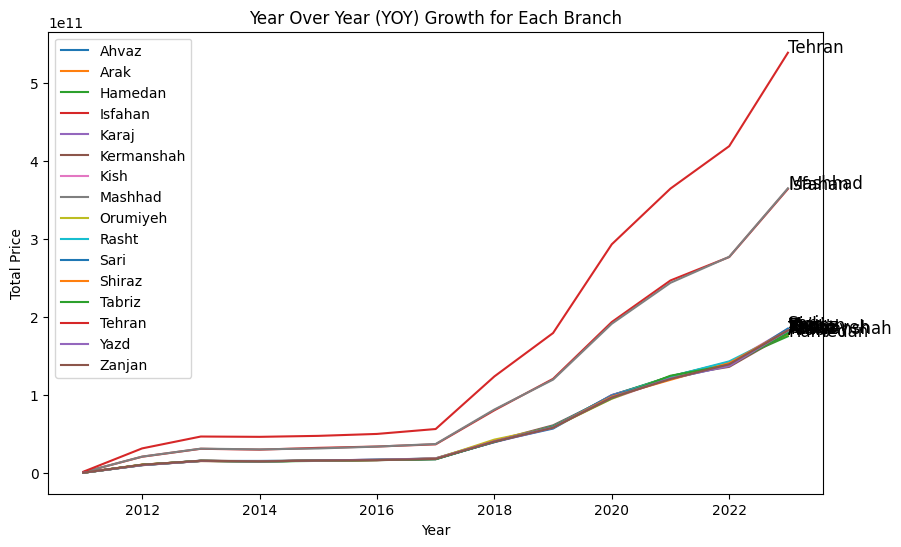

In [390]:
# YOY growth plot for each branch over the years

fig, ax = plt.subplots(figsize=(10, 6))
for branch in df1_yoy.index:
    ax.plot(df1_yoy.columns, df1_yoy.loc[branch], label=branch)
    ax.text(
        df1_yoy.columns[-1], df1_yoy.loc[branch, df1["Year"].max()], branch, fontsize=12
    )
ax.set_title("Year Over Year (YOY) Growth for Each Branch")
ax.set_xlabel("Year")
ax.set_ylabel("Total Price")
ax.legend()
plt.show()

In [391]:
# Extract key indexes for each branch

city_data = (
    df1.groupby("Branch")
    .agg(
        total_orders=pd.NamedAgg(column="Order_ID", aggfunc="count"),
        total_profit=pd.NamedAgg(column="Profit", aggfunc="sum"),
        avg_discount=pd.NamedAgg(column="Discount", aggfunc="mean"),
        avg_profit=pd.NamedAgg(column="Profit", aggfunc="mean"),
        avg_aov=pd.NamedAgg(column="AOV", aggfunc="mean"),
    )
    .reset_index()
)

city_data["yoy"] = df1_yoy.iloc[:, -1].values

city_data

,Branch,total_orders,total_profit,avg_discount,avg_profit,avg_aov,yoy
0,Ahvaz,50793,73179880000,0.601677,1.440747e+06,1.300790e+07,179796886989
1,Arak,50915,73322370000,0.603260,1.440094e+06,1.310881e+07,177905378988
2,Hamedan,50984,73304140000,0.603464,1.437787e+06,1.304174e+07,175609979491
3,Isfahan,101698,146746110000,0.604673,1.442960e+06,1.312369e+07,364541763987
4,Karaj,51078,73290360000,0.591116,1.434871e+06,1.303892e+07,180780317991
5,Kermanshah,50904,73213100000,0.598067,1.438258e+06,1.303609e+07,179713147989
6,Kish,50747,73430860000,0.607267,1.446999e+06,1.313472e+07,184830274493
7,Mashhad,101684,146242020000,0.603477,1.438201e+06,1.304930e+07,365323838977
8,Orumiyeh,50914,73123930000,0.607750,1.436224e+06,1.307974e+07,180245385994
9,Rasht,50851,73780300000,0.602623,1.450911e+06,1.316426e+07,180930126989


In [392]:
# Create sorted table of branches in each key index

top_n = 16
top_df = pd.DataFrame()

for col in city_data.columns:
    if col != "Branch":
        top_df[col] = city_data.nlargest(top_n, col)["Branch"].values
top_df

,total_orders,total_profit,avg_discount,avg_profit,avg_aov,yoy
0,Tehran,Tehran,Sari,Rasht,Rasht,Tehran
1,Isfahan,Isfahan,Shiraz,Sari,Kish,Mashhad
2,Mashhad,Mashhad,Orumiyeh,Kish,Isfahan,Isfahan
3,Karaj,Rasht,Kish,Isfahan,Sari,Sari
4,Hamedan,Sari,Yazd,Zanjan,Arak,Kish
5,Shiraz,Shiraz,Tabriz,Shiraz,Shiraz,Zanjan
6,Arak,Kish,Isfahan,Yazd,Zanjan,Shiraz
7,Orumiyeh,Arak,Mashhad,Ahvaz,Orumiyeh,Yazd
8,Kermanshah,Hamedan,Hamedan,Arak,Tehran,Rasht
9,Rasht,Karaj,Arak,Tehran,Tabriz,Karaj


In [393]:
# Create Rank table of branches in each key index

rank_df = city_data.copy()
for column in top_df.columns:
    rank_df[column] = city_data[column].rank().astype(int)

rank_df

,Branch,total_orders,total_profit,avg_discount,avg_profit,avg_aov,yoy
0,Ahvaz,4,4,5,9,1,5
1,Arak,10,9,7,8,12,2
2,Hamedan,12,8,8,3,5,1
3,Isfahan,15,15,10,13,14,14
4,Karaj,13,7,1,1,4,7
5,Kermanshah,8,6,3,5,3,4
6,Kish,2,10,13,14,15,12
7,Mashhad,14,14,9,4,6,15
8,Orumiyeh,9,3,14,2,9,6
9,Rasht,7,13,6,16,16,8


### Rationale:
We have two types of market ahead:
- Established:
    with strong market presence: High Orders, High Profits & High Year-Over-Year-Growth
- Emerging:
    with more growth potential > Marketable: High Average Discount, High Average Order Value & High Year-Over-Year-Growth

In [394]:
# Established Market Weights
alpha_e = 0.5   # Total Orders
beta_e = 0.4    # Total Profit
gamma_e = 0.1   # YOY Growth of Last Year

# Emerging Market Weights
alpha_m = 0.4   # Average Discount Rate
beta_m = 0.4    # Average Order of Value
gamma_m = 0.2   # YOY Growth of Last Year

In [395]:
# Calculate score for each branch by market type

score_df = rank_df.copy()

score_df["Established Score"] = (
    alpha_e * score_df["total_orders"]
    + beta_e * score_df["total_profit"]
    + gamma_e * score_df["yoy"]
)

score_df["Emerging Score"] = (
    alpha_m * score_df["avg_discount"]
    + beta_m * score_df["avg_aov"]
    + gamma_m * score_df["yoy"]
)

established_cities = score_df[["Branch", "Established Score"]].sort_values(
    by="Established Score", ascending=False
)
emerging_cities = score_df[["Branch", "Emerging Score"]].sort_values(
    by="Emerging Score", ascending=False
)

In [396]:
established_cities

,Branch,Established Score
13,Tehran,16.0
3,Isfahan,14.9
7,Mashhad,14.1
11,Shiraz,10.9
4,Karaj,10.0
9,Rasht,9.5
2,Hamedan,9.3
10,Sari,9.1
1,Arak,8.8
5,Kermanshah,6.8


In [397]:
emerging_cities

,Branch,Emerging Score
10,Sari,14.2
6,Kish,13.6
3,Isfahan,12.4
11,Shiraz,12.4
8,Orumiyeh,10.4
9,Rasht,10.4
7,Mashhad,9.0
1,Arak,8.0
13,Tehran,8.0
12,Tabriz,7.8


### Result
Choose two from either:
- Top branches in established market: **Tehran** & **Isfahan**
- Top branched in emerging market: **Sari** & **kish**

*Hint:* <br>
    **Isfahan** & **Shiraz** are in top five of both markets and they seem to be promising!

<br>

> Cities for furthur advertisement: <br>
> **Tehran**, **Isfahan**, **Sari**, **Kish**, **Shiraz**

---

## Client Order #2

از آنجایی که شرکت دوباره شروع به کار کرده است می‌خواهد ببیند آیا تخفیف رو‌ی میزان فروش تاثیر دارد؟ و نحوه تاثیر یا عدم تاثیر را نمایش دهید.

**Hypothesis**: <br>
"Discount has a significant impact on the sales of laptop.” <br><br>

Null Hypothesis (**H<sub>0</sub>**): Discount has no significant impact on the sales of laptop. <br>
Alternative Hypothesis (**H<sub>a</sub>**): Discount has a significant impact on the sales of laptop.

In [398]:
# Filter coumns needed for analyze

cols_for_analyze_2 = [
    "Discount",
    "Total_Price",
]
df2 = df[cols_for_analyze_2].copy()

df2["Discount_Applied"] = df2["Discount"] > 0

df2.head()

,Discount,Total_Price,Discount_Applied
0,0,3450000,False
1,0,3400000,False
2,0,44900000,False
3,0,12550000,False
4,0,2050000,False


In [399]:
# Calculate average sales by discount

average_sales_by_discount = df2.groupby("Discount_Applied")["Total_Price"].mean()

average_sales_by_discount

Discount_Applied
False    1.455367e+07
True     1.393049e+07
Name: Total_Price, dtype: float64

Average Total Price without discount    =   14_553_670  IRT <br>
Average Total Price with discount       =   13_930_490  IRT <br>

**Doesn't provide enough evidence**

In [400]:
# Split data into two groups: with discount and without discount

df_with_discount = pd.DataFrame(df2[df2["Discount_Applied"] == True]["Total_Price"])
df_without_discount = pd.DataFrame(df2[df2["Discount_Applied"] == False]["Total_Price"])

In [401]:
# Define function to plot two histograms above each other with mean values

def create_double_histogram(df1, df2, df1_label, df2_label, title, column_name="price"):
    mean_1 = df1[column_name].mean()
    mean_2 = df2[column_name].mean()

    plt.figure(figsize=(7, 5))
    sns.histplot(data=df1, x=column_name, color="blue", kde=True, label=df1_label)
    sns.histplot(data=df2, x=column_name, color="red", kde=True, label=df2_label)

    mean_text_y = plt.ylim()[1] / 2

    plt.axvline(mean_1, color="blue", linestyle="--")
    plt.text(mean_1, mean_text_y, f"{mean_1:,.2}", rotation=0, color="blue")

    plt.axvline(mean_2, color="red", linestyle="--")
    plt.text(mean_2, mean_text_y + 50, f"{mean_2:,.2}", rotation=0, color="red")

    plt.title(title, loc="center")
    plt.legend()
    plt.tight_layout()
    plt.show()

Skewness for applied discount sales: 3.65
Skewness for non-applied discount sales: 3.45


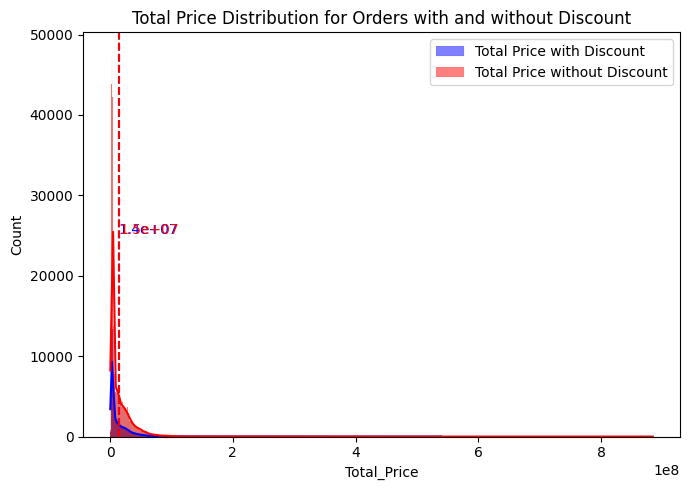

In [402]:
# Measure skewness for each group
# Plot the histogram for the final dataframes

skewness_total_price_with_discount = df_with_discount["Total_Price"].skew()
skewness_total_price_without_discount = df_without_discount["Total_Price"].skew()

print(f"Skewness for applied discount sales: {skewness_total_price_with_discount:,.2f}")
print(f"Skewness for non-applied discount sales: {skewness_total_price_without_discount:,.2f}")

create_double_histogram(
    df_with_discount,
    df_without_discount,
    "Total Price with Discount",
    "Total Price without Discount",
    title="Total Price Distribution for Orders with and without Discount",
    column_name="Total_Price",
)

Skewness for applied discount sales after boxcox transform: 0.06
Skewness for non-applied discount sales after boxcox transform: 0.06


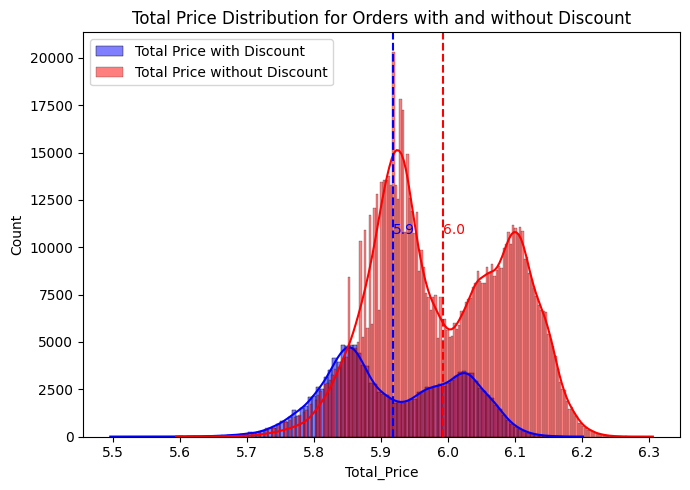

In [403]:
# Apply BOXCOX transformation on both groups
# Measure skewness for each group
# Plot the histogram for the final dataframes

df_with_discount["Total_Price"], _ = boxcox(df_with_discount["Total_Price"])
df_without_discount["Total_Price"], _ = boxcox(df_without_discount["Total_Price"])

skewness_total_price_with_discount = df_with_discount["Total_Price"].skew()
skewness_total_price_without_discount = df_without_discount["Total_Price"].skew()

print(f"Skewness for applied discount sales after boxcox transform: {skewness_total_price_with_discount:,.2f}")
print(f"Skewness for non-applied discount sales after boxcox transform: {skewness_total_price_without_discount:,.2f}")

create_double_histogram(
    df_with_discount,
    df_without_discount,
    "Total Price with Discount",
    "Total Price without Discount",
    title="Total Price Distribution for Orders with and without Discount",
    column_name="Total_Price",
)

In [404]:
# Apply t-test to check if the difference between two groups is significant

t_stat, p_value = ttest_ind(
    df_with_discount["Total_Price"], df_without_discount["Total_Price"]
)
print(f"t-statistic: {t_stat:.5f}")
print(f"p-value: {p_value:.20}")

t-statistic: -269.81477
p-value: 0.0


> P-Valye << **0.000** indicates that the observed data is extremely inconsistent with the null hypothesis. <br>
> T-STAT < **0** indicates increasing dicount rate relates to decreasing the sale but it can mean different things. <br>
    For instance, if the goal of the discount was to clear out old stock, then even if the revenue was lower with discounts, the strategy might still be deemed successful. <br><br>
> This leads to the **REJECTION** of the null hypothesis(H<sub>0</sub>) in favor of the alternative hypothesis (H<sub>a</sub>). <br><br>
> **This suggests that based on the data, there is very strong evidence to conclude that applying discount on laptop sales has a significant impact on the Total Sale Value.**

---

## Client Oder #3

پیرو درخواست قبلی برخی از مدیران شرکت می‌ترسند تخفیف دادن باعث کاهش سود شود برای همین از شما خواسته‌اند تا تاثیر تخفیف بر میزان سود را نیز بررسی کنید و در صورت وجود این تاثیر، آن را شرح دهید.

**Hypothesis**: <br>
"Discount has a significant impact on the sales' profit.” <br><br>

Null Hypothesis (**H<sub>0</sub>**): Discount has no significant impact on the profit. <br>
Alternative Hypothesis (**H<sub>a</sub>**): Discount has a significant impact on the profit.

In [405]:
# Filter & modify columns needed for analyze

cols_for_analyze_3 = [
    "Discount",
    "Profit",
]
df3 = df[cols_for_analyze_3].copy()

df3["Discount_Applied"] = df3["Discount"] > 0

df3.head()

,Discount,Profit,Discount_Applied
0,0,250000,False
1,0,380000,False
2,0,5630000,False
3,0,1130000,False
4,0,180000,False


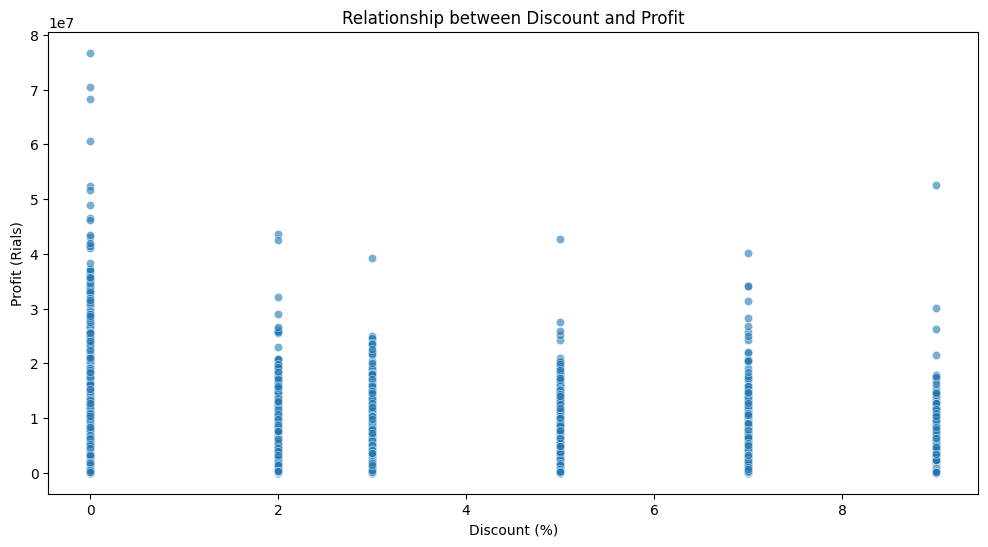

In [406]:
# Scatter plot between Discount and Profit

plt.figure(figsize=(12, 6))
sns.scatterplot(x=df3["Discount"], y=df3["Profit"], alpha=0.6)
plt.title("Relationship between Discount and Profit")
plt.xlabel("Discount (%)")
plt.ylabel("Profit (Rials)")
plt.show()

In [407]:
# Calculate the correlation between Discount and Profit

correlation = df3["Discount"].corr(df3["Profit"])

correlation

-0.013094112416811717

> This value is very close to zero, indicating a very weak negative linear relationship between discounts and profits. <br>
> Other factors might play a more critical role in determining the profit.

In [408]:
# Calculate the average profit for each discount group

average_profit_by_discount = df3.groupby("Discount_Applied")["Profit"].mean()

average_profit_by_discount

Discount_Applied
False    1.450280e+06
True     1.388569e+06
Name: Profit, dtype: float64

Average profit without discount    =   1_450_280  IRT <br>
Average profit with discount       =   1_388_569  IRT <br>

**Doesn't provide enough evidence**

In [409]:
# Split data into two groups: with discount and without discount

df3_with_discount = pd.DataFrame(df3[df3["Discount_Applied"] == True]["Profit"])
df3_without_discount = pd.DataFrame(df3[df3["Discount_Applied"] == False]["Profit"])

Skewness for applied discount sales: 3.71
Skewness for non-applied discount sales: 3.56


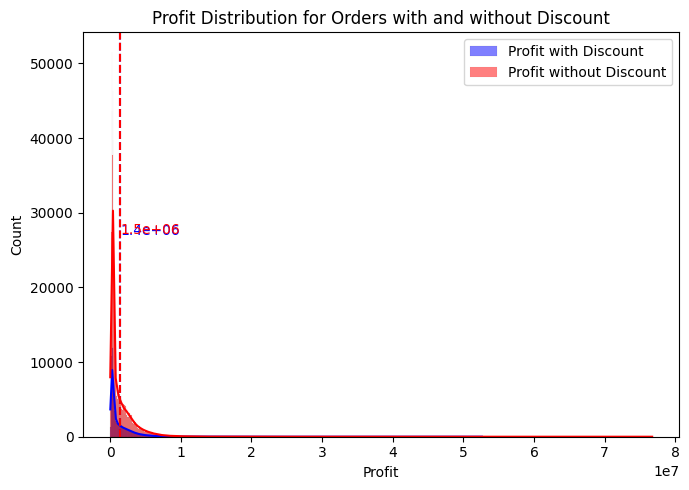

In [410]:
# Measure skewness for each group
# Plot the histogram for the final dataframes

skewness_profit_with_discount = df3_with_discount["Profit"].skew()
skewness_profit_without_discount = df3_without_discount["Profit"].skew()

print(f"Skewness for applied discount sales: {skewness_profit_with_discount:,.2f}")
print(f"Skewness for non-applied discount sales: {skewness_profit_without_discount:,.2f}")

create_double_histogram(
    df3_with_discount,
    df3_without_discount,
    "Profit with Discount",
    "Profit without Discount",
    title="Profit Distribution for Orders with and without Discount",
    column_name="Profit",
)

Skewness for applied discount sales after boxcox transform: 0.05
Skewness for non-applied discount sales after boxcox transform: 0.05


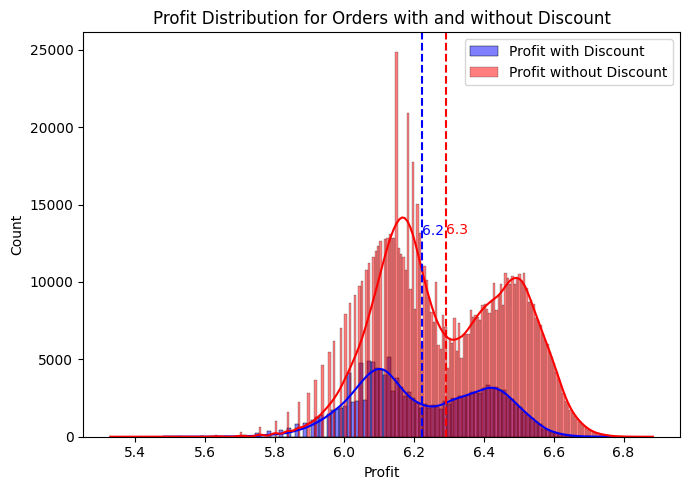

In [411]:
# Apply BOXCOX transformation for both groups
# Measure skewness for each group
# Plot the histogram for the final dataframes

df3_with_discount["Profit"], _ = boxcox(df3_with_discount["Profit"])
df3_without_discount["Profit"], _ = boxcox(df3_without_discount["Profit"])

skewness_profit_with_discount = df3_with_discount["Profit"].skew()
skewness_profit_without_discount = df3_without_discount["Profit"].skew()

print(f"Skewness for applied discount sales after boxcox transform: {skewness_profit_with_discount:,.2f}")
print(f"Skewness for non-applied discount sales after boxcox transform: {skewness_profit_without_discount:,.2f}")

create_double_histogram(
    df3_with_discount,
    df3_without_discount,
    "Profit with Discount",
    "Profit without Discount",
    title="Profit Distribution for Orders with and without Discount",
    column_name="Profit",
)

In [412]:
# Apply t-test to check if the difference between two groups is significant

t_stat, p_value = ttest_ind(df3_with_discount["Profit"], df3_without_discount["Profit"])

print(f"t-statistic: {t_stat:.5f}")
print(f"p-value: {p_value:.20}")

t-statistic: -130.83815
p-value: 0.0


> P-Valye << **0.000** indicates that the observed data is extremely inconsistent with the null hypothesis. <br>
> T-STAT < **0** indicates increasing dicount rate relates to decreasing the profit but it can mean different things. <br>
    For instance, if the goal of the discount was to clear out old stock, then even if the revenue was lower with discounts, the strategy might still be deemed successful. <br><br>
> This leads to the **REJECTION** of the null hypothesis(H<sub>0</sub>) in favor of the alternative hypothesis (H<sub>a</sub>). <br><br>
> **This suggests that, based on the data, there is very strong evidence to conclude that applying discount on laptop sales has a significant impact on the Profit gained.** <br><br>
> Considering low correlation coefficient, it seems the discount is not the most strong or evident parameter effecting profit.

---

## Client Oder #4

در آینده‌ای نزدیک شرکت می‌خواهد لپ‌تاپ‌های جدیدی را وارد کند و از شما می‌خواهد تا بگویید سرمایه خود را به چه نحوی بین برند‌ها و دسته‌بندی‌های مختلف لپ‌تاپ تقسیم کند.

In [413]:
# Filter columns needed for analysis and create a new dataframe

cols_for_analyze_4 = [
    "Order_Date",
    "Order_Priority",
    "Manufacturer",
    "Category",
    "Price",
    "Total_Price",
    "Quantity",
    "Profit",
]

df4 = df[cols_for_analyze_4].copy()
df4.head()

,Order_Date,Order_Priority,Manufacturer,Category,Price,Total_Price,Quantity,Profit
0,2018-01-16,H,Dell,Notebook,3450000,3450000,1,250000
1,2015-07-12,H,Lenovo,2 in 1 Convertible,3400000,3400000,1,380000
2,2023-08-15,M,Lenovo,Notebook,44900000,44900000,1,5630000
3,2018-09-08,H,Dell,Ultrabook,12550000,12550000,1,1130000
4,2013-12-21,L,Acer,Notebook,2050000,2050000,1,180000


In [414]:
# Modify columns to: "Profit per device": 'Profit', and "Total Order Profit": 'Total_Profit'

df4["Profit"] = df4["Profit"] / df4["Quantity"]
df4["Total_Profit"] = df4["Profit"] * df4["Quantity"]

df4.head()

,Order_Date,Order_Priority,Manufacturer,Category,Price,Total_Price,Quantity,Profit,Total_Profit
0,2018-01-16,H,Dell,Notebook,3450000,3450000,1,250000.0,250000.0
1,2015-07-12,H,Lenovo,2 in 1 Convertible,3400000,3400000,1,380000.0,380000.0
2,2023-08-15,M,Lenovo,Notebook,44900000,44900000,1,5630000.0,5630000.0
3,2018-09-08,H,Dell,Ultrabook,12550000,12550000,1,1130000.0,1130000.0
4,2013-12-21,L,Acer,Notebook,2050000,2050000,1,180000.0,180000.0


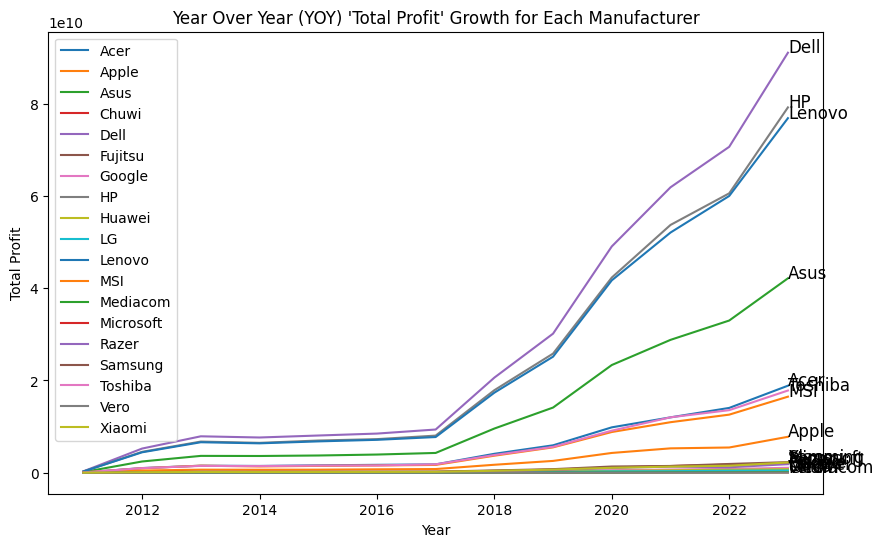

In [415]:
# Add column 'Year', Group by 'Year' & 'Manufacturer', & Plot YOY growth of Total Profit for each manufacturer

df4["Year"] = df4["Order_Date"].dt.year

df4_yoy_Manufacturer = (
    df4.groupby(["Year", "Manufacturer"]).agg({"Total_Profit": "sum"}).reset_index()
)
df4_yoy_Manufacturer = df4_yoy_Manufacturer.pivot(
    index="Manufacturer", columns="Year", values="Total_Profit"
)

fig, ax = plt.subplots(figsize=(10, 6))
for manufacturer in df4_yoy_Manufacturer.index:
    ax.plot(
        df4_yoy_Manufacturer.columns,
        df4_yoy_Manufacturer.loc[manufacturer],
        label=manufacturer,
    )
    ax.text(
        df4_yoy_Manufacturer.columns[-1],
        df4_yoy_Manufacturer.loc[manufacturer, df4["Year"].max()],
        manufacturer,
        fontsize=12,
    )
ax.set_title("Year Over Year (YOY) 'Total Profit' Growth for Each Manufacturer")
ax.set_xlabel("Year")
ax.set_ylabel("Total Profit")
ax.legend()
plt.show()

**Dell**, **HP**, **Lenovo** & **ASUS** are the brands with most total profit over the years.

In [416]:
# List of top manufacturers by total profit

total_profit_by_brand = (
    df4.groupby("Manufacturer")["Total_Profit"].sum().sort_values(ascending=False)
)

total_profit_by_brand

Manufacturer
Dell         3.704426e+11
HP           3.198779e+11
Lenovo       3.125165e+11
Asus         1.728327e+11
Acer         7.398900e+10
Toshiba      7.087452e+10
MSI          6.670011e+10
Apple        3.112172e+10
Samsung      9.467740e+09
Microsoft    8.490480e+09
Xiaomi       8.220260e+09
Razer        7.176360e+09
Google       4.200320e+09
Fujitsu      3.449380e+09
Huawei       3.224240e+09
LG           2.098290e+09
Mediacom     4.936100e+08
Chuwi        3.003900e+08
Vero         1.253600e+08
Name: Total_Profit, dtype: float64

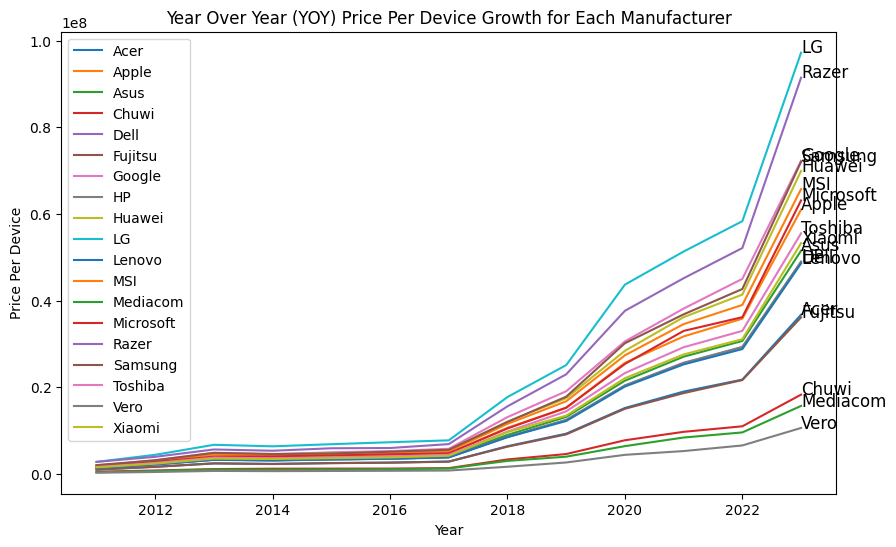

In [417]:
# Add column 'Year', Group by 'Year' & 'Manufacturer', & Plot YOY growth pf profit per device for each manufacturer

df4_yoy_Manufacturer = (
    df4.groupby(["Year", "Manufacturer"]).agg({"Price": "mean"}).reset_index()
)
df4_yoy_Manufacturer = df4_yoy_Manufacturer.pivot(
    index="Manufacturer", columns="Year", values="Price"
)

fig, ax = plt.subplots(figsize=(10, 6))
for manufacturer in df4_yoy_Manufacturer.index:
    ax.plot(
        df4_yoy_Manufacturer.columns,
        df4_yoy_Manufacturer.loc[manufacturer],
        label=manufacturer,
    )
    ax.text(
        df4_yoy_Manufacturer.columns[-1],
        df4_yoy_Manufacturer.loc[manufacturer, df4["Year"].max()],
        manufacturer,
        fontsize=12,
    )
ax.set_title("Year Over Year (YOY) Price Per Device Growth for Each Manufacturer")
ax.set_xlabel("Year")
ax.set_ylabel("Price Per Device")
ax.legend()
plt.show()

**LG**, **Razor**, **Google** & **Samsung** are the brands with increase in profit per device and seem emerging.

In [418]:
# List of top manufacturers by price per device

price_by_brand = (
    df4.groupby("Manufacturer")["Price"].mean().sort_values(ascending=False)
)

price_by_brand

Manufacturer
LG           2.577851e+07
Razer        2.360394e+07
Google       2.020352e+07
Samsung      1.869120e+07
Huawei       1.791272e+07
MSI          1.724588e+07
Microsoft    1.662286e+07
Apple        1.594372e+07
Toshiba      1.491629e+07
Xiaomi       1.427246e+07
Asus         1.369611e+07
HP           1.296945e+07
Dell         1.293588e+07
Lenovo       1.282996e+07
Acer         9.761597e+06
Fujitsu      9.543999e+06
Chuwi        4.930607e+06
Mediacom     4.171304e+06
Vero         2.766945e+06
Name: Price, dtype: float64

Suggested Allocation by Brands:

- Top 3 brands (Dell, HP, Lenovo): Allocate 50% of funds.<br>
    Dell: 20%, HP: 15%, Lenovo: 15%.
- Next 4-7 brands (ASUS, Acer, TOSHIBA, MSI, Apple): Allocate 25% of evenly.
- Remaining brands: Allocate the remaining 25%.
    Prioritize emerging brands like LG, Razer, and Google.


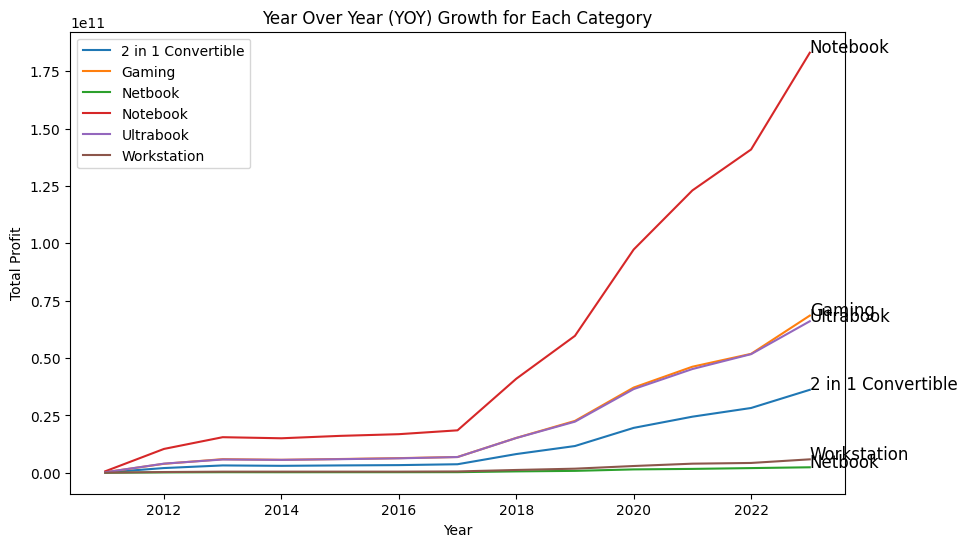

In [419]:
# Add column 'Year', Group by 'Year' & 'Category', & Plot YOY growth of Total Profit for each category

df4_yoy_category = (
    df4.groupby(["Year", "Category"]).agg({"Total_Profit": "sum"}).reset_index()
)
df4_yoy_category = df4_yoy_category.pivot(
    index="Category", columns="Year", values="Total_Profit"
)

fig, ax = plt.subplots(figsize=(10, 6))
for category in df4_yoy_category.index:
    ax.plot(df4_yoy_category.columns, df4_yoy_category.loc[category], label=category)
    ax.text(
        df4_yoy_category.columns[-1],
        df4_yoy_category.loc[category, df4["Year"].max()],
        category,
        fontsize=12,
    )
ax.set_title("Year Over Year (YOY) Growth for Each Category")
ax.set_xlabel("Year")
ax.set_ylabel("Total Profit")
ax.legend()
plt.show()

In [420]:
# List of top categories by total profit

total_profit_by_category = (
    df4.groupby("Category")["Total_Profit"].sum().sort_values(ascending=False)
)

total_profit_by_category

Category
Notebook              7.380291e+11
Gaming                2.763986e+11
Ultrabook             2.714495e+11
2 in 1 Convertible    1.467489e+11
Workstation           2.275983e+10
Netbook               1.021573e+10
Name: Total_Profit, dtype: float64

**Notebook**, **Gaming**, & **Ultrabook** are the best performing laptop categories.

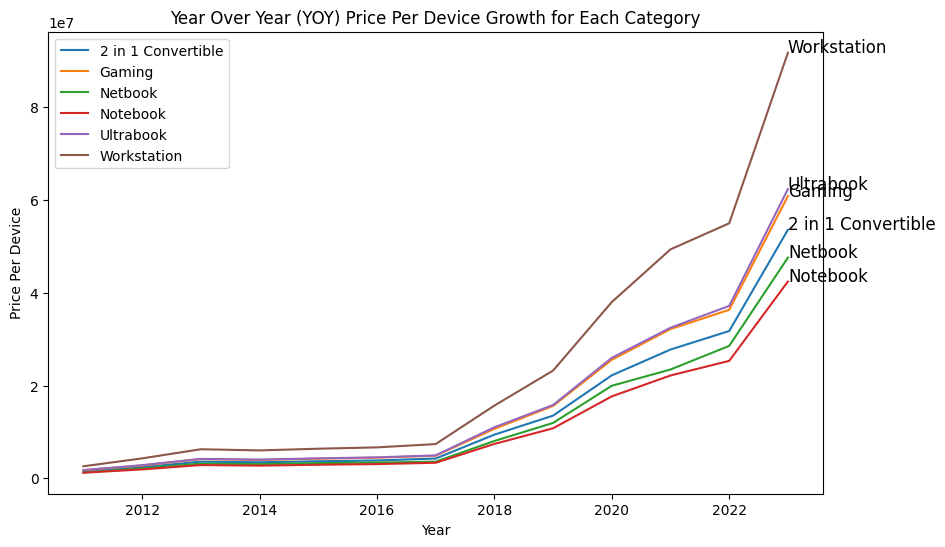

In [421]:
# Add column 'Year', Group by 'Year' & 'Category', & Plot YOY growth pf profit per device for each category

df4_yoy_Category = (
    df4.groupby(["Year", "Category"]).agg({"Price": "mean"}).reset_index()
)
df4_yoy_Category = df4_yoy_Category.pivot(
    index="Category", columns="Year", values="Price"
)

fig, ax = plt.subplots(figsize=(10, 6))
for category in df4_yoy_Category.index:
    ax.plot(df4_yoy_Category.columns, df4_yoy_Category.loc[category], label=category)
    ax.text(
        df4_yoy_Category.columns[-1],
        df4_yoy_Category.loc[category, df4["Year"].max()],
        category,
        fontsize=12,
    )
ax.set_title("Year Over Year (YOY) Price Per Device Growth for Each Category")
ax.set_xlabel("Year")
ax.set_ylabel("Price Per Device")
ax.legend()
plt.show()

In [422]:
# List of top categories by price per device

price_by_category = df4.groupby("Category")["Price"].mean().sort_values(ascending=False)

price_by_category

Category
Workstation           2.486757e+07
Ultrabook             1.644058e+07
Gaming                1.623699e+07
2 in 1 Convertible    1.411108e+07
Netbook               1.234426e+07
Notebook              1.123027e+07
Name: Price, dtype: float64

**Workstation** & **Ultrabook** & **Gaming** are the brands with increase in profit per device and seem emerging.

Suggested Allocation by Categories:

- Notebook: $40%
- Ultrabook & Gaming: 20% each
- 20% for remaining categories


---

## Client Order #5

از آنجا که شرکت مدت زیادی را دور از بازار بوده و در این مدت قیمت‌ها ثباتی نداشته‌اند، از شما خواسته شده تا راهکاری را ارائه دهید تا با داشتن مشخصات فنی یک لپ‌تاپ بتوان قیمت آن را در بازار پیش‌بینی کند.

In [423]:
# Filter columns needed for analysis and create a new dataframe

cols_for_analyze_5 = [
    "Order_Date",
    "Manufacturer",
    "Category",
    "Screen_Size",
    "Screen_resolution",
    "RAM",
    "OS",
    "Weight",
    "CPU_Brand",
    "CPU_Model",
    "CPU_GHZ",
    "Storage_SSD",
    "Storage_HDD",
    "Storage_Hybrid",
    "Storage_Flash",
    "Storage_Total",
    "GPU_Brand",
    "GPU_Model",
    "Price",
]
df5 = df[cols_for_analyze_5].copy()

df5.head()

,Order_Date,Manufacturer,Category,Screen_Size,Screen_resolution,RAM,OS,Weight,CPU_Brand,CPU_Model,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Price
0,2018-01-16,Dell,Notebook,15.6,1920x1080,8,Windows,2.18,Intel,Core i5 7200U,2.5,256,0,0,0,256,AMD,Radeon R5 M420,3450000
1,2015-07-12,Lenovo,2 in 1 Convertible,13.3,1920x1080,8,Windows,1.30,Intel,Core i5 7200U,2.5,256,0,0,0,256,Intel,HD Graphics 620,3400000
2,2023-08-15,Lenovo,Notebook,15.6,1920x1080,8,Windows,2.60,Intel,Core i7 6700HQ,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,44900000
3,2018-09-08,Dell,Ultrabook,13.3,1920x1080,8,Windows,1.40,Intel,Core i7 8550U,1.8,256,0,0,0,256,AMD,Radeon 530,12550000
4,2013-12-21,Acer,Notebook,15.6,1920x1080,4,Windows,2.23,Intel,Core i5 7200U,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,2050000


In [424]:
# convert Screen_resolution to Screen_resolution_width and Screen_resolution_height

df5["Screen_resolution_width"] = (
    df5["Screen_resolution"].str.split("x").str[0].astype(int)
)
df5["Screen_resolution_height"] = (
    df5["Screen_resolution"].str.split("x").str[1].astype(int)
)
df5.drop("Screen_resolution", axis=1, inplace=True)
df5.drop(
    "Screen_resolution_height", axis=1, inplace=True
)  # high correlation with Screen_resolution_width

df5.head()

,Order_Date,Manufacturer,Category,Screen_Size,RAM,OS,Weight,CPU_Brand,CPU_Model,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Price,Screen_resolution_width
0,2018-01-16,Dell,Notebook,15.6,8,Windows,2.18,Intel,Core i5 7200U,2.5,256,0,0,0,256,AMD,Radeon R5 M420,3450000,1920
1,2015-07-12,Lenovo,2 in 1 Convertible,13.3,8,Windows,1.30,Intel,Core i5 7200U,2.5,256,0,0,0,256,Intel,HD Graphics 620,3400000,1920
2,2023-08-15,Lenovo,Notebook,15.6,8,Windows,2.60,Intel,Core i7 6700HQ,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,44900000,1920
3,2018-09-08,Dell,Ultrabook,13.3,8,Windows,1.40,Intel,Core i7 8550U,1.8,256,0,0,0,256,AMD,Radeon 530,12550000,1920
4,2013-12-21,Acer,Notebook,15.6,4,Windows,2.23,Intel,Core i5 7200U,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,2050000,1920


In [425]:
# Add column 'Year' & drop column 'Order_Date'

df5["Year"] = df5["Order_Date"].dt.year
df5.drop("Order_Date", axis=1, inplace=True)

### CPI :: Consumer Price Index
The CPI is an index that measures the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services.<br>
It is one of the most widely used statistics for identifying periods of inflation or deflation.



Consumer Price Index for Islamic Republic of Iran   <br>
Source 1: https://fred.stlouisfed.org/series/DDOE01IRA086NWDB   <br>
Source 2: https://ycharts.com/indicators/iran_consumer_price_index_wdi  <br>
Source 3: https://tradingeconomics.com/iran/consumer-price-index-cpi    <br>

In [426]:
# Update prices based on CPI (Consumer Price Index) values

cpi_values = {
    2010: 106.52,
    2011: 130.086,
    2012: 177.219,
    2013: 229.694,
    2014: 268.342,
    2015: 293.48,
    2016: 319.56,
    2017: 351.61,
    2018: 393.78,
    2019: 550.93,
    2020: 719.48,
    2021: 1031.66,
    2022: 1211.5619,
    2023: 2144.3869,
}

df5["Price_Adjusted"] = df5.apply(
    lambda row: row["Price"] * (cpi_values[2023] / cpi_values[row["Year"]]), axis=1
)
df_adjusted_prices = df5[["Year", "Price", "Price_Adjusted"]]
df5.drop("Price", axis=1, inplace=True)
df5.rename(columns={"Price_Adjusted": "Price"}, inplace=True)
df5.drop("Year", axis=1, inplace=True)

df5.head()

,Manufacturer,Category,Screen_Size,RAM,OS,Weight,CPU_Brand,CPU_Model,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Screen_resolution_width,Price
0,Dell,Notebook,15.6,8,Windows,2.18,Intel,Core i5 7200U,2.5,256,0,0,0,256,AMD,Radeon R5 M420,1920,1.878748e+07
1,Lenovo,2 in 1 Convertible,13.3,8,Windows,1.30,Intel,Core i5 7200U,2.5,256,0,0,0,256,Intel,HD Graphics 620,1920,2.484297e+07
2,Lenovo,Notebook,15.6,8,Windows,2.60,Intel,Core i7 6700HQ,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,1920,4.490000e+07
3,Dell,Ultrabook,13.3,8,Windows,1.40,Intel,Core i7 8550U,1.8,256,0,0,0,256,AMD,Radeon 530,1920,6.834287e+07
4,Acer,Notebook,15.6,4,Windows,2.23,Intel,Core i5 7200U,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,1920,1.913848e+07


CPU Ranking Rationale:
- Cortex, E-Series, and Atom models are ranked as the least powerful.
- Celeron and Pentium models are ranked next.
- Core M and some AMD series like A4, A6, A8, A9, A10, and A12 follow.
- Xeon, FX, and Ryzen models are ranked higher.
- Core i3, Core i5, and Core i7 models are ranked in ascending order of their power, and within each series, they are ranked by their generation and model number.

In [427]:
# Order CPU models by performance
# Create a dictionary of CPU models and their rank
# Map the rank to CPU_Model column

cpu_list = df5["CPU_Model"].unique()

sorted_cpus = sorted(
    cpu_list,
    key=lambda x: (
        -1
        if "Core i7" in str(x)
        else -2
        if "Core i5" in str(x)
        else -3
        if "Core i3" in str(x)
        else -4
        if "Ryzen" in str(x) or "FX" in str(x)
        else -5
        if "Xeon" in str(x)
        else -6
        if "A12-Series" in str(x) or "A10-Series" in str(x)
        else -7
        if "A9-Series" in str(x)
        or "A8-Series" in str(x)
        or "A6-Series" in str(x)
        or "A4-Series" in str(x)
        else -8
        if "Core M" in str(x)
        else -9
        if "Pentium" in str(x)
        else -10
        if "Celeron" in str(x)
        else -11
        if "Atom" in str(x)
        else -12
        if "E-Series" in str(x)
        else -13,  # For others or NaN values
        str(x),  # To sort by name within the same category
    ),
)

cpu_rank = {cpu: rank + 1 for rank, cpu in enumerate(sorted_cpus)}

df5["CPU_Model"] = df5["CPU_Model"].map(cpu_rank)

df5["CPU_Model"].value_counts()

CPU_Model
64    200242
80    123235
84     97516
71     86008
88     82621
       ...  
6         98
8         91
11        91
22        86
79        76
Name: count, Length: 89, dtype: int64

In [428]:
# Fill Null values in 'CPU_GHZ' and 'CPU_Brand' columns,
# with the most frequent value for each manufacturer


def fill_cpu_mode(group, column_name):
    mode_value = group[column_name].mode().iloc[0]
    return group.fillna({column_name: mode_value})


df5 = df5.groupby("Manufacturer").apply(fill_cpu_mode, "CPU_GHZ").reset_index(drop=True)
df5 = df5.groupby("Manufacturer").apply(fill_cpu_mode, "CPU_Brand").reset_index(drop=True)
df5 = df5.groupby("Manufacturer").apply(fill_cpu_mode, "CPU_Model").reset_index(drop=True)

df5.head()

,Manufacturer,Category,Screen_Size,RAM,OS,Weight,CPU_Brand,CPU_Model,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Screen_resolution_width,Price
0,Acer,Notebook,15.6,4,Windows,2.23,Intel,64,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,1920,1.913848e+07
1,Acer,2 in 1 Convertible,14.0,8,Windows,1.20,Intel,87,1.3,256,0,0,0,256,Intel,HD Graphics 615,1920,7.838630e+07
2,Acer,Notebook,17.3,8,Windows,3.00,Intel,71,1.6,256,0,0,0,256,Nvidia,GeForce MX150,1920,4.845918e+07
3,Acer,Notebook,15.6,4,Windows,2.40,AMD,42,2.2,0,500,0,0,500,AMD,Radeon R5,1366,1.743387e+07
4,Acer,Notebook,15.6,8,Windows,2.40,Intel,64,2.5,256,1024,0,0,1280,Nvidia,GeForce GTX 950M,1920,7.242537e+07


GPU Ranking Rationale:
- GPU Series: For example, NVIDIA's GeForce GTX 1080 would typically be more powerful than a GeForce GTX 1070, and so on.
- GPU Brand: NVIDIA's GTX and RTX series are often considered high-end, whereas their MX series targets the mid-range market.<br>
    Similarly, AMD's Radeon RX series can be high-end, while their Radeon R series might be considered mid to low-end.
- Integrated vs. Dedicated: Integrated graphics like Intel's HD Graphics or Iris Graphics are typically less powerful than dedicated GPUs.
- Memory and Clock Speed: Higher memory and faster clock speeds can offer better performance, but these specifics aren't provided in the list.

In [429]:
# Order GPU models by performance
# Create a dictionary of GPU models and their rank
# Map the rank to GPU_Model column

gpu_list = df5["GPU_Model"].unique()

sorted_gpus = sorted(
    gpu_list,
    key=lambda x: (
        -1
        if "GeForce GTX 1080" in str(x)
        else -2
        if "GeForce GTX 1070" in str(x)
        else -3
        if "GeForce GTX 1060" in str(x)
        else -4
        if "GeForce GTX 1050" in str(x)
        else -5
        if "GeForce GTX 980" in str(x)
        else -6
        if "Radeon RX 580" in str(x) or "Radeon RX 560" in str(x)
        else -7
        if "Quadro" in str(x)
        else -8
        if "GeForce GTX 9" in str(x) or "GeForce MX" in str(x)
        else -9
        if "Radeon R9" in str(x) or "Radeon R7" in str(x)
        else -10
        if "Radeon R5" in str(x)
        else -11
        if "Iris" in str(x)
        else -12
        if "HD Graphics" in str(x) or "UHD Graphics" in str(x)
        else -13
        if "FirePro" in str(x)
        else -14
        if "GeForce 9" in str(x)
        else -15,  # For other GPUs or NaN values
        str(x),  # To sort by name within the same category
    ),
)

gpu_rank = {gpu: rank + 1 for rank, gpu in enumerate(sorted_gpus)}

df5["GPU_Model"] = df5["GPU_Model"].map(gpu_rank)

df5["GPU_Model"].value_counts()

GPU_Model
51     243848
45     136888
103     76205
54      70777
12      49213
        ...  
109        92
14         89
33         89
98         85
1          76
Name: count, Length: 110, dtype: int64

In [430]:
# Label Encoding for categorical columns

categorical_cols = [
    "Manufacturer",
    "Category",
    "OS",
    "CPU_Brand",
    "GPU_Brand",
]

le_manufacturer = LabelEncoder()
le_category = LabelEncoder()
le_os = LabelEncoder()
le_cpu_brand = LabelEncoder()
le_gpu_brand = LabelEncoder()

df5["Manufacturer"] = le_manufacturer.fit_transform(df5["Manufacturer"])
df5["Category"] = le_category.fit_transform(df5["Category"])
df5["OS"] = le_os.fit_transform(df5["OS"])
df5["CPU_Brand"] = le_cpu_brand.fit_transform(df5["CPU_Brand"])
df5["GPU_Brand"] = le_gpu_brand.fit_transform(df5["GPU_Brand"])

In [431]:
# Try: Drop Storge-subject columns to drop based on correlation matrix

df5.drop("Storage_Total", axis=1, inplace=True)  # high correlation with Storage_HDD
# df5.drop(columns=['Storage_SSD', 'Storage_HDD', 'Storage_Hybrid', 'Storage_Flash'], axis=1, inplace=True)

In [432]:
# Try: Drop Weight column because of high correlation

# df5.drop('Weight', axis=1, inplace=True)  # high correlation with Screen Size

In [433]:
# Create correlation matrix

df5_corr_matrix = df5.corr()

df5_corr_matrix > 0.8

,Manufacturer,Category,Screen_Size,RAM,OS,Weight,CPU_Brand,CPU_Model,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,GPU_Brand,GPU_Model,Screen_resolution_width,Price
Manufacturer,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Category,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Screen_Size,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
RAM,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
OS,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
Weight,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
CPU_Brand,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
CPU_Model,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
CPU_GHZ,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
Storage_SSD,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


<Axes: >

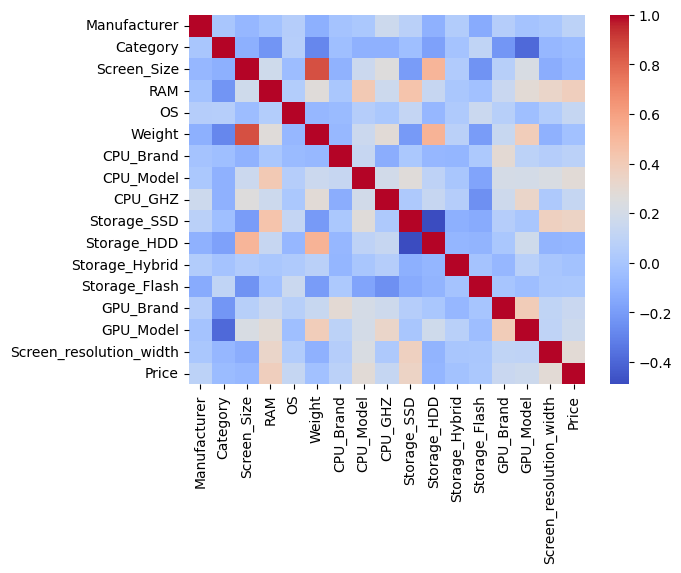

In [434]:
# Plot heatmap of correlation matrix

sns.heatmap(df5_corr_matrix, annot=False, cmap="coolwarm")

In [435]:
# One Hot Encoding for categorical columns

df5 = pd.get_dummies(
    df5,
    columns=categorical_cols,
    drop_first=False,
)

df5.head()

,Screen_Size,RAM,Weight,CPU_Model,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,GPU_Model,...,OS_3,OS_4,OS_5,CPU_Brand_0,CPU_Brand_1,CPU_Brand_2,GPU_Brand_0,GPU_Brand_1,GPU_Brand_2,GPU_Brand_3
0,15.6,4,2.23,64,2.5,256,0,0,0,32,...,False,True,False,False,True,False,False,False,False,True
1,14.0,8,1.20,87,1.3,256,0,0,0,50,...,False,True,False,False,True,False,False,False,True,False
2,17.3,8,3.00,71,1.6,256,0,0,0,87,...,False,True,False,False,True,False,False,False,False,True
3,15.6,4,2.40,42,2.2,0,500,0,0,60,...,False,True,False,True,False,False,True,False,False,False
4,15.6,8,2.40,64,2.5,256,1024,0,0,80,...,False,True,False,False,True,False,False,False,False,True


In [436]:
# Create Feature set and Target set for ML
# Split data into train and test sets
# Scale the data

X = df5.drop("Price", axis=1)
y = df5["Price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=274
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((864518, 49), (152563, 49), (864518,), (152563,))

In [437]:
# # Apply PolynomialFeatures to create new features

# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_train = poly.fit_transform(X_train)
# X_test = poly.transform(X_test)

# X_train.shape, X_test.shape

In [438]:
# Apply PCA to reduce the number of features

from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

X_train.shape, X_test.shape

((864518, 31), (152563, 31))

In [439]:
# Train the model

rf_reg = xgb.XGBRegressor()
# rf_reg = RandomForestRegressor()
# rf_reg = LinearRegression()

rf_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [440]:
# Predict the test set, and calculate MSE & R2 score

y_pred = rf_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:,.2f}")
print(f"R2 Score: {r2:.2%}")

Mean Squared Error: 293,747,831,247,433.19
R2 Score: 44.26%


Best R<sup>2</sup> = 44.27%